# Imports

In [48]:
import os
import torch
import torch.nn as nn
import numpy as np
from IPython import embed
from skimage import color
from PIL import Image
import ssl
from tqdm.notebook import trange, tqdm
from torchvision import transforms
from torchvision.datasets import Caltech256
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import CIFAR10, Caltech256
from matplotlib import pyplot as plt

In [105]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Model 2: Encoder Decoder w/Feature Extractor


Data Processing and Dataset Preparation when using Flickr30k

In [ ]:
#Pre processing of data to index rbg training data

def preProcessing(path, w=256, h=256):
  if not os.path.exists(path + "/../train"):
    os.mkdir(path + "/../train")

  idx=0
  for filename in os.listdir(path):
    if not os.path.isdir(path + "/" + filename) and ".csv" not in filename:
      
      #get RGB image, resize, and put in rgb folder
      rgb_img=Image.open(path + "/" + filename)
      #rgb_img=rgb_img.resize((w, h))
      rgb_img.save(path + "/../train/" + str(idx) + "_rgb.png")

      idx+=1
      if idx>11000:
        break

In [179]:
#Set up dataset so images are indexed
preProcessing("/content/flickr30k_images/flickr30k_images", 256, 256)

In [13]:
from skimage import io
class myEDDataset(Dataset):
  def __init__(self, img_dir):
    self.img_dir=img_dir
    paths = os.listdir(self.img_dir)
    self.dataset_length = len(paths)
    self.paths = list(map(lambda x: os.path.join(self.img_dir, x), paths))
  
  def __len__(self):
    return int((self.dataset_length))

  def __getitem__(self, idx):
    path = self.paths[idx]
    rgb=Image.open(path)
    rgb_resh=rgb.resize((32, 32))

    #Get CIE-Lab equivalent of the RGB image
    clab_array=color.rgb2lab(np.asarray(rgb_resh, dtype = np.float32))

    #Get greyscale CIE-Lab equivalent of the RGB image
    clab_grayarray = clab_array[:, :, 0]
    clab_grayarray = clab_grayarray[np.newaxis,:, :]

    clab_array=clab_array[:, :, 1:3]
    clab_array = clab_array.transpose((2, 0, 1)) # (2, 224, 224)

    #get incep input
    target_img=rgb.resize((299, 299))
    incep_array=color.rgb2lab(np.asarray(target_img, dtype = np.float32))
    incep_array = incep_array.transpose((2, 0, 1)) # (3, 299, 299)

    #Transform
    input=clab_grayarray
    target=clab_array
    incep=incep_array

    data={'input': input, 'target': target, 'incep': incep}

    return data

Data Pre-processing for CIFAR10

In [65]:
#Prepare CIFAR10 dataset; split into train, val, and test subsets
def import_image(img):
    #convert to LAB
    img=(color.rgb2lab(np.array(img)))

    #normalize and reshape
    img=(img+128)/255
    img=np.transpose((img), (2, 0, 1))
    return torch.FloatTensor(img)

img_transform = transforms.Compose([
    transforms.Lambda(import_image)
])

batch_size=8

train_dataset = CIFAR10("./data/CIFAR10", train=True, transform=img_transform, target_transform=None, download=True)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.9, 0.1])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10("./data/CIFAR10", train=False, transform=img_transform, target_transform=None, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Data Pre-processing for CalTech256

In [17]:
#Prepare CalTech256 datasetl split into train, val, and test subsets
from torchvision.datasets.caltech import Caltech256
def import_image(img):
    img=np.array(img)
    if len(img.shape)<3:
      img=np.stack((img, )*3, axis=-1)

    img=Image.fromarray(img)

    return torch.FloatTensor(np.transpose(color.rgb2lab(np.array(img)), (2, 0, 1)))

img_transform = transforms.Compose([
    transforms.Lambda(import_image),
    transforms.Resize((299, 299))
])

batch_size=8

train_dataset = Caltech256("./data/Caltech256", transform=img_transform, target_transform=None, download=True)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [0.9, 0.1])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = Caltech256("./data/Caltech256", transform=img_transform, target_transform=None, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

1183006720it [00:23, 50815196.65it/s]


Extracting ./data/Caltech256/caltech256/256_ObjectCategories.tar to ./data/Caltech256/caltech256
Files already downloaded and verified


Colorization Model based on [Deep Koalarization](https://arxiv.org/pdf/1712.03400.pdf) and [Model Implementations of Deep Koalarization](https://github.com/lauradang/automatic-image-colorization)

In [7]:
%%capture
!pip install pretrainedmodels

In [8]:
import pretrainedmodels
from pretrainedmodels import utils

In [153]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
      
    self.layer1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1)

    self.layer2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

    self.layer3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)

    self.layer4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)

    self.layer5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1)

    self.layer6 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)

    self.layer7 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)

    self.layer8 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
    x=F.relu(self.layer1(x))
    x=F.relu(self.layer2(x))
    x=F.relu(self.layer3(x))
    x=F.relu(self.layer4(x))
    x=F.relu(self.layer5(x))
    x=F.relu(self.layer6(x))
    x=F.relu(self.layer7(x))
    x=F.relu(self.layer8(x))

    return x

In [154]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()

    self.layer1=nn.Conv2d(in_channels=1257, out_channels=256, kernel_size=1)

    self.layer2=nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1)

    self.layer3=nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)

    self.layer4=nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

    self.layer5=nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
    
    self.layer6=nn.Conv2d(in_channels=32, out_channels=2, kernel_size=3, padding=1)

  def forward(self, x):
    x=F.relu(self.layer1(x))
    x=F.relu(self.layer2(x))
    x=F.interpolate(x, scale_factor=2)
    
    x=F.relu(self.layer3(x))
    x=F.relu(self.layer4(x))
    x=F.interpolate(x, scale_factor=2)

    x=F.relu(self.layer5(x))
    x=torch.tanh(self.layer6(x))
    x=F.interpolate(x, scale_factor=2)

    return x

In [178]:
%%capture
#feature extractor
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
inception = pretrainedmodels.__dict__["inceptionresnetv2"](
            num_classes=1001, 
            pretrained="imagenet+background")
inception.eval()

In [148]:
class EDModel(nn.Module):
    def __init__(self):
      super(EDModel, self).__init__()

      self.encoder=Encoder()
      self.decoder=Decoder()

    def forward(self, x, feature):

      enout=self.encoder(x)

      extract_feat=inception(feature)
      extract_feat=extract_feat.view(-1, 1001, 1, 1)
      
      rows = torch.cat([extract_feat] * 4, dim=3)
      embedding_block = torch.cat([rows] * 4, dim=2)
      fusion_block = torch.cat([enout, embedding_block], dim=1)
      
      out=self.decoder(fusion_block)

      return out

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [155]:
#Our refined version of F.mse_loss
def bmse_loss(inputs, targets):
    mse_loss = (inputs - targets) ** 2
    weights = torch.log(torch.abs(targets)+1)+1
    mse_loss = mse_loss*weights
    mse_loss = mse_loss.mean()/torch.sum(weights)
    return mse_loss

#Training loop
def train(model, train_loader, optimizer, device):
  model.train()

  #Track progress of training
  pbar=None
  pbar=tqdm(train_loader, leave=True, total=len(train_loader))
  
  total_loss=0.0
  for idx, data in enumerate(pbar):

    #Resize input, target, and feature
    feature=(data[0])
    feature=(feature.resize_(8, 3, 299, 299)).to(device)
    input=(((data[0].resize_(8, 3, 32, 32)))[:, 0:1, :, :]).to(device)
    target=(((data[0].resize_(8, 3, 32, 32)))[:, 1:3, :, :]).to(device)
    
    optimizer.zero_grad()
    output=model(input, feature)
    loss = F.mse_loss(output, target)

    loss.backward()
    optimizer.step()

    total_loss+=loss.item()
  
  return total_loss/len(train_loader)

#Validation loop
def val(model, val_loader, device):
  model.eval()

  #Track progress of validation
  pbar=None
  pbar=tqdm(val_loader, leave=True, total=len(val_loader))
  
  total_loss=0.0
  for idx, data in enumerate(pbar):

    #Resize input, target, and feature
    feature=(data[0])
    feature=(feature.resize_(8, 3, 299, 299)).to(device)
    input=(((data[0].resize_(8, 3, 32, 32)))[:, 0:1, :, :]).to(device)
    target=(((data[0].resize_(8, 3, 32, 32)))[:, 1:3, :, :]).to(device)

    output=model(input, feature)
    loss = F.mse_loss(output, target)

    total_loss+=loss.item()
    
  return total_loss/len(val_loader)

In [ ]:
#EDModel
model = EDModel()
model.to(device)

#Inception Model for Feature Extraction
inception.to(device)

#optimizer
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

#Keep track of loss
training_loss=[]
validation_loss=[]

MAX_EPOCHS=20
latest_loss=10000000000000
for epoch in range(MAX_EPOCHS):
  print("Epoch " + str(epoch) + "/" + str(MAX_EPOCHS))

  train_loss=train(model, train_dataloader, optimizer, device)
  val_loss=val(model, val_dataloader, device)

  print("-----------------------------------------")
  print("Train loss: " + str(train_loss))
  print("Val loss: " + str(val_loss))
  print("-----------------------------------------")

  training_loss.append(train_loss)
  validation_loss.append(val_loss)

  #Save best version of the model
  if val_loss<latest_loss:
    torch.save(model.state_dict(), '/content/drive/MyDrive/checkpoint.pt')

Epoch 0/20


  0%|          | 0/5625 [00:00<?, ?it/s]

([<matplotlib.axis.XTick at 0x7fd6fd622250>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20')])

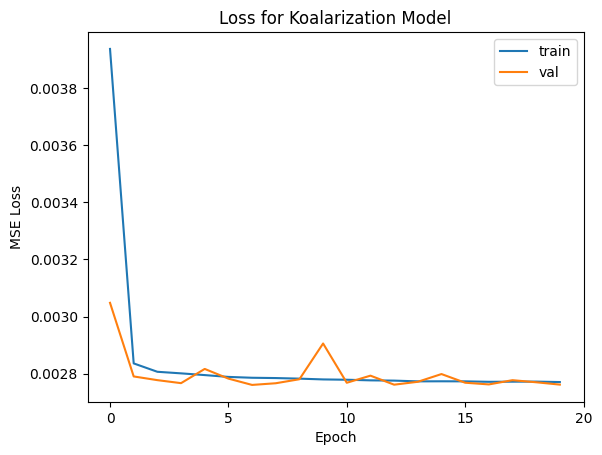

In [93]:
#Create Graphs for Train and Val loss
plt.plot(training_loss, label="train")
plt.plot(validation_loss, label="val")
plt.legend()
plt.title("Loss for Koalarization Model")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.xticks(np.arange(0, 25, 5))

#Evaluation

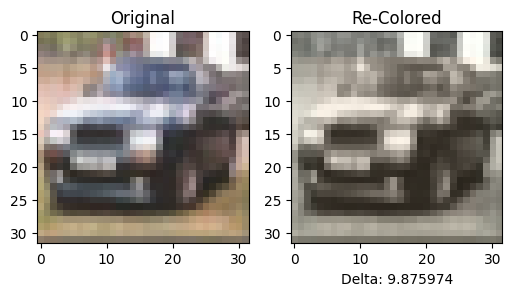

In [177]:
#Visualization + Evaluation of Data

#DELTA E 76
#https://stackoverflow.com/questions/60257518/how-can-i-calculate-the-colorspace-delta-e-in-python-using-only-opencv-numpy-sci
#http://zschuessler.github.io/DeltaE/learn/

#load model
model=EDModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/checkpointFINAL1.pt'))
model.to(device)
model.eval()

#parse through test photos
for idx, data in enumerate(test_dataloader):

    #Resize feature, input; pass through the model to get the pred_ab
    feature=(data[0])
    feature=(feature.resize_(1, 3, 299, 299)).to(device)
    input_L=(((data[0].resize_(1, 3, 32, 32)))[:, 0:1, :, :]).to(device)
    pred_ab=model(input_L, feature)

    #Get original image and reshape
    orig_img=np.transpose(((data[0]).numpy())[0, :, :, :], (1, 2, 0))

    #Concatenate the input L value and output a and b values to get the LAB image
    out_img=np.transpose(
        (torch.cat([input_L, pred_ab], dim=1))
        .cpu()
        .detach()
        .numpy()[0, :, :, :], 
        (1, 2, 0)
        )

    #Undo normalization applied when processing images
    orig_img[:, :, 0]=(orig_img[:, :, 0]*255)-128
    orig_img[:, :, 1]=(orig_img[:, :, 1]*255)-128
    orig_img[:, :, 2]=(orig_img[:, :, 2]*255)-128
    out_img[:, :, 0]=(out_img[:, :, 0]*255)-128
    out_img[:, :, 1]=(out_img[:, :, 1]*255)-128
    out_img[:, :, 2]=(out_img[:, :, 2]*255)-128

    #get diff between out and original images
    diff=orig_img-out_img

    diffL=diff[:, :, 0]
    diffa=diff[:, :, 1]
    diffb=diff[:, :, 2]

    #Get delta value
    delta=np.mean(np.sqrt((diffL*diffL)+(diffa*diffa)+(diffb*diffb)))

    #Visualize the output and target images
    rgb_orig_img=color.lab2rgb(orig_img)
    rgb_out_img=color.lab2rgb(out_img)

    img_plot=[rgb_orig_img, rgb_out_img]
    
    fig, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=2)
    ax[0].imshow(rgb_orig_img)
    ax[0].title.set_text('Original')
    ax[1].imshow(rgb_out_img)
    ax[1].title.set_text('Re-Colored')
    
    plt.xlabel('Delta: ' + str(delta))
    plt.show()

    #delete to allow ALL test pictures to be processed
    break




References: \\
https://github.com/lauradang/automatic-image-colorization/blob/master/notebooks/inception_resnet.ipynb \\
https://arxiv.org/pdf/1712.03400.pdf \\
http://zschuessler.github.io/DeltaE/learn/ \\
https://stackoverflow.com/questions/60257518/how-can-i-calculate-the-colorspace-delta-e-in-python-using-only-opencv-numpy-sci \\
https://github.com/baldassarreFe/deep-koalarization \\
https://www.cs.toronto.edu/~kriz/cifar.html \\
https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset \\
https://data.caltech.edu/records/nyy15-4j048
